In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
# when reading full dataset, skip last 2 rows because they are NaN
raw_data = pd.read_csv("dataset1.csv", skipfooter=2)
# print first and last 5 rows 
print(raw_data.head())
print(raw_data[["Time"]].iloc[-5:])

C:\Users\zpatel\Miniconda3\envs\cs229\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


      Time  DAC S0  SO (volts)  DAC S1  S1 (volts)  DAC S2  S2 (volts)  \
0  00:00.9       2         2.0   0.499         0.5     0.5         0.5   
1  00:01.9       2         2.0   0.499         0.5     0.5         0.5   
2  00:02.9       2         2.0   0.499         0.5     0.5         0.5   
3  00:03.9       2         2.0   0.499         0.5     0.5         0.5   
4  00:04.9       2         2.0   0.499         0.5     0.5         0.5   

   DAC S3  S3 (volts)  DAC S4  ...  Extractor 3  Extractor 4  Extractor 5  \
0     0.5         0.5   0.501  ...      -176.38      -225.05      -192.70   
1     0.5         0.5   0.501  ...      -176.35      -225.05      -192.73   
2     0.5         0.5   0.501  ...      -176.41      -225.02      -192.70   
3     0.5         0.5   0.501  ...      -176.41      -224.99      -192.73   
4     0.5         0.5   0.501  ...      -176.35      -225.02      -192.70   

   Extractor 6  BLA 1  BLA 2  BLA 3  BLA 4  BLA 5  BLA 6  
0      -183.08 -30.06 -35.29 -36.

In [3]:
# convert Minute:Second time stamps into proper datetime typed Time column.

raw_data.reset_index(inplace=True)
#print("Reset Index\n", raw_data.head())
raw_data["Time"] = raw_data["Time"].astype(str).apply(lambda x: x[:-2])
raw_data["Hour"] = raw_data["index"].floordiv(3600).apply(lambda x: str(x) if x >=10 else "0" + str(x))
raw_data["Day"] = raw_data["Hour"].astype(int).floordiv(24).apply(lambda x: str(x + 1) if (x + 1) >=10 else "0" + str(x + 1))
raw_data["Hour"] = raw_data["Hour"].apply(lambda x: int(x) % 24)
raw_data["Time"] = raw_data["Day"].astype(str) + ":" + raw_data["Hour"].astype(str) + ":" + raw_data["Time"].astype(str)
raw_data.set_index("index", inplace=True, drop=True)
#print("Added Hour to Time\n", raw_data.head())
# %M:%S format turns a reading into minutes:seconds and drops the fractional seconds (since sampling period is 2s)
raw_data['Time'] = pd.to_datetime(raw_data['Time'], format="%d:%H:%M:%S", exact=False)
raw_data['Seconds'] = raw_data['Time'].dt.second
#print("Converted Time to DTime\n", raw_data.head())

# show that last 2 rows are NaN when full dataset is read in (without skipfooter)
#print(raw_data.iloc[-3:])

In [4]:
# Column Exploration:
raw_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 775215 entries, 0 to 775214
Data columns (total 51 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Time                    775215 non-null  datetime64[ns]
 1   DAC S0                  775215 non-null  int64         
 2   SO (volts)              775215 non-null  float64       
 3   DAC S1                  775215 non-null  float64       
 4   S1 (volts)              775215 non-null  float64       
 5   DAC S2                  775215 non-null  float64       
 6   S2 (volts)              775215 non-null  float64       
 7   DAC S3                  775215 non-null  float64       
 8   S3 (volts)              775215 non-null  float64       
 9   DAC S4                  775215 non-null  float64       
 10  S4 (volts)              775215 non-null  float64       
 11  DAC S5                  775215 non-null  float64       
 12  S5 (volts)              775215

In [5]:
# Explore how time data is handled:
# print last item
print(raw_data[["Time"]].iloc[-1])

# print first 100 items
raw_data[["Time"]].iloc[:100]


Time   1900-01-09 23:59:59
Name: 775214, dtype: datetime64[ns]


,Time
index,
0,1900-01-01 00:00:00
1,1900-01-01 00:00:01
2,1900-01-01 00:00:02
3,1900-01-01 00:00:03
4,1900-01-01 00:00:04
...,...
95,1900-01-01 00:01:36
96,1900-01-01 00:01:37
97,1900-01-01 00:01:38


In [6]:
# Resample data to 1 sample per minute
# drop all columns but extractor values while we are at it
def quant(q):
    # spits out a quantile generating function for using 
    return lambda x: x.quantile(q)

filtered_extractors = (
    raw_data[['Time', 'Extractor 1', 'Extractor 2', 'Extractor 3', 'Extractor 4', 'Extractor 5', 'Extractor 6']]
    .resample(rule="min", on="Time", )
    .agg([quant(.05), 'mean', quant(.95)])
    .rename({"<lambda_0>":"5th quantile", "<lambda_1>": "95th quantile"})
)
print("Old #rows: %d, Filtered #rows: %d" %(len(raw_data), len(filtered_extractors)))
# Check that index was updated properly
#print(filtered_extractors.index)
filtered_extractors.head()

Old #rows: 775215, Filtered #rows: 12960


Extractor 1                        Extractor 2  \
                     <lambda_0>        mean <lambda_1>  <lambda_0>   
Time                                                                 
1900-01-01 00:00:00    -183.950 -183.511954   -182.670   -157.4300   
1900-01-01 00:01:00    -183.890 -180.447500   -179.490   -157.4315   
1900-01-01 00:02:00    -179.713 -179.618983   -179.490   -157.4030   
1900-01-01 00:03:00    -179.800 -179.733833   -179.650   -157.4000   
1900-01-01 00:04:00    -179.843 -179.621017   -179.174   -157.4300   

                                           Extractor 3                         \
                           mean <lambda_1>  <lambda_0>        mean <lambda_1>   
Time                                                                            
1900-01-01 00:00:00 -157.218851   -156.930     -176.97 -176.533103    -176.29   
1900-01-01 00:01:00 -157.366167   -157.300     -176.35 -176.281500    -176.19   
1900-01-01 00:02:00 -157.350678   -157.270     -176.26 -176.185763    -176.10   
1900-01-01 00:03:00 -157.327333   -157.240     -176.22 -176.156667    -176.07   
1900-01-01 00:04:00 -157.356441   -157.267     -176.26 -176.160169    -176.07   

                    Extractor 4                        Extractor 5  \
                     <lambda_0>        mean <lambda_1>  <lambda_0>   
Time                                                                 
1900-01-01 00:00:00   -225.1400 -224.579655    -223.51   -192.7600   
1900-01-01 00:01:00   -225.0515 -224.998500    -224.93   -192.7600   
1900-01-01 00:02:00   -224.9900 -224.948814    -224.90   -192.7000   
1900-01-01 00:03:00   -225.0200 -224.913333    -224.84   -192.6715   
1900-01-01 00:04:00   -224.9330 -224.871186    -224.80   -192.6730   

                                           Extractor 6                         
                           mean <lambda_1>  <lambda_0>        mean <lambda_1>  
Time                                                                           
1900-01-01 00:00:00 -192.598161    -192.30    -183.890 -183.317701  -183.0200  
1900-01-01 00:01:00 -192.666000    -192.61    -183.210 -183.120667  -183.0785  
1900-01-01 00:02:00 -192.657288    -192.61    -183.113 -183.069492  -183.0200  
1900-01-01 00:03:00 -192.636500    -192.58    -183.170 -183.109500  -183.0500  
1900-01-01 00:04:00 -192.651695    -192.61    -183.240 -183.174915  -183.1100

In [7]:
# Resample data to 1 sample per minute
# drop all columns but BLA values while we are at it


filtered_bla = (
    raw_data[['Time', 'BLA 1', 'BLA 2', 'BLA 3', 'BLA 4', 'BLA 5', 'BLA 6']]
    .resample(rule="min", on="Time", )
    .agg([quant(.05), 'mean', quant(.95)])
    .rename({"<lambda_0>":"5th quantile", "<lambda_1>": "95th quantile"})
)
print("Old #rows: %d, Filtered #rows: %d" %(len(raw_data), len(filtered_bla)))
print(filtered_bla.index)

#filtered_bla = filtered_bla.apply(lambda x: x - x.mean())
filtered_bla.head()

Old #rows: 775215, Filtered #rows: 12960
DatetimeIndex(['1900-01-01 00:00:00', '1900-01-01 00:01:00',
               '1900-01-01 00:02:00', '1900-01-01 00:03:00',
               '1900-01-01 00:04:00', '1900-01-01 00:05:00',
               '1900-01-01 00:06:00', '1900-01-01 00:07:00',
               '1900-01-01 00:08:00', '1900-01-01 00:09:00',
               ...
               '1900-01-09 23:50:00', '1900-01-09 23:51:00',
               '1900-01-09 23:52:00', '1900-01-09 23:53:00',
               '1900-01-09 23:54:00', '1900-01-09 23:55:00',
               '1900-01-09 23:56:00', '1900-01-09 23:57:00',
               '1900-01-09 23:58:00', '1900-01-09 23:59:00'],
              dtype='datetime64[ns]', name='Time', length=12960, freq=None)


BLA 1                            BLA 2             \
                    <lambda_0>       mean <lambda_1> <lambda_0>       mean   
Time                                                                         
1900-01-01 00:00:00   -30.1410 -30.036667   -29.9600    -35.500 -35.325632   
1900-01-01 00:01:00   -30.0315 -29.960000   -29.8985    -35.600 -35.484500   
1900-01-01 00:02:00   -30.0630 -29.967119   -29.8670    -35.560 -35.449492   
1900-01-01 00:03:00   -30.0600 -29.964167   -29.8700    -35.560 -35.431667   
1900-01-01 00:04:00   -30.0630 -29.983729   -29.9000    -35.636 -35.498814   

                                    BLA 3                            BLA 4  \
                    <lambda_1> <lambda_0>       mean <lambda_1> <lambda_0>   
Time                                                                         
1900-01-01 00:00:00     -35.13    -36.500 -36.023678   -35.1800   -38.7000   
1900-01-01 00:01:00     -35.38    -36.440 -36.333833   -36.1895   -38.6300   
1900-01-01 00:02:00     -35.38    -36.320 -36.227119   -36.1270   -38.6000   
1900-01-01 00:03:00     -35.32    -36.250 -36.150500   -36.0400   -38.6315   
1900-01-01 00:04:00     -35.29    -36.193 -36.101186   -35.9800   -38.6000   

                                               BLA 5                        \
                          mean <lambda_1> <lambda_0>       mean <lambda_1>   
Time                                                                         
1900-01-01 00:00:00 -38.438276    -38.022     -35.22 -35.116552    -34.889   
1900-01-01 00:01:00 -38.571000    -38.510     -35.22 -35.116833    -35.030   
1900-01-01 00:02:00 -38.531864    -38.480     -35.19 -35.114746    -35.030   
1900-01-01 00:03:00 -38.527500    -38.450     -35.16 -35.069667    -34.970   
1900-01-01 00:04:00 -38.527288    -38.480     -35.19 -35.098475    -35.030   

                         BLA 6                        
                    <lambda_0>       mean <lambda_1>  
Time                                                  
1900-01-01 00:00:00   -33.3510 -33.213218   -33.0800  
1900-01-01 00:01:00   -33.3900 -33.278333   -33.1985  
1900-01-01 00:02:00   -33.2600 -33.154915   -33.0800  
1900-01-01 00:03:00   -33.3015 -33.164333   -33.0800  
1900-01-01 00:04:00   -33.3000 -33.181864   -33.1100

In [8]:
bla_reset_index = filtered_bla.reset_index()
# center data by taking the mean

bla_reset_index.head()


Time      BLA 1                            BLA 2             \
                      <lambda_0>       mean <lambda_1> <lambda_0>       mean   
0 1900-01-01 00:00:00   -30.1410 -30.036667   -29.9600    -35.500 -35.325632   
1 1900-01-01 00:01:00   -30.0315 -29.960000   -29.8985    -35.600 -35.484500   
2 1900-01-01 00:02:00   -30.0630 -29.967119   -29.8670    -35.560 -35.449492   
3 1900-01-01 00:03:00   -30.0600 -29.964167   -29.8700    -35.560 -35.431667   
4 1900-01-01 00:04:00   -30.0630 -29.983729   -29.9000    -35.636 -35.498814   

                  BLA 3                            BLA 4             \
  <lambda_1> <lambda_0>       mean <lambda_1> <lambda_0>       mean   
0     -35.13    -36.500 -36.023678   -35.1800   -38.7000 -38.438276   
1     -35.38    -36.440 -36.333833   -36.1895   -38.6300 -38.571000   
2     -35.38    -36.320 -36.227119   -36.1270   -38.6000 -38.531864   
3     -35.32    -36.250 -36.150500   -36.0400   -38.6315 -38.527500   
4     -35.29    -36.193 -36.101186   -35.9800   -38.6000 -38.527288   

                  BLA 5                            BLA 6                        
  <lambda_1> <lambda_0>       mean <lambda_1> <lambda_0>       mean <lambda_1>  
0    -38.022     -35.22 -35.116552    -34.889   -33.3510 -33.213218   -33.0800  
1    -38.510     -35.22 -35.116833    -35.030   -33.3900 -33.278333   -33.1985  
2    -38.480     -35.19 -35.114746    -35.030   -33.2600 -33.154915   -33.0800  
3    -38.450     -35.16 -35.069667    -34.970   -33.3015 -33.164333   -33.0800  
4    -38.480     -35.19 -35.098475    -35.030   -33.3000 -33.181864   -33.1100

In [9]:
mean_models = []
max_models = []
min_models = []
#bla_reset_index["seconds"] = pd.to_timedelta(bla_reset_index["Time"]).dt.total_seconds()
bla_reset_index["seconds"] = bla_reset_index.index
bla_reset_index.dropna(axis=0, inplace=True)
bla_reset_index.info(verbose=True)
print(bla_reset_index["seconds"])
for col in ['BLA 1', 'BLA 2', 'BLA 3', 'BLA 4', 'BLA 5', 'BLA 6']:
    data = bla_reset_index.index.to_numpy().reshape(-1, 1)
    #print(data[:10])
    mean_reg = LinearRegression(fit_intercept=True).fit(data, bla_reset_index[col]['mean'])
    mean_models.append(mean_reg)
    
for model in mean_models:
    print(model.coef_, model.intercept_)
    













<class 'pandas.core.frame.DataFrame'>
Int64Index: 12921 entries, 0 to 12959
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   (Time, )             12921 non-null  datetime64[ns]
 1   (BLA 1, <lambda_0>)  12921 non-null  float64       
 2   (BLA 1, mean)        12921 non-null  float64       
 3   (BLA 1, <lambda_1>)  12921 non-null  float64       
 4   (BLA 2, <lambda_0>)  12921 non-null  float64       
 5   (BLA 2, mean)        12921 non-null  float64       
 6   (BLA 2, <lambda_1>)  12921 non-null  float64       
 7   (BLA 3, <lambda_0>)  12921 non-null  float64       
 8   (BLA 3, mean)        12921 non-null  float64       
 9   (BLA 3, <lambda_1>)  12921 non-null  float64       
 10  (BLA 4, <lambda_0>)  12921 non-null  float64       
 11  (BLA 4, mean)        12921 non-null  float64       
 12  (BLA 4, <lambda_1>)  12921 non-null  float64       
 13  (BLA 5, <lambda_0>)  12921 non-

Text(0.5,0,'Time')

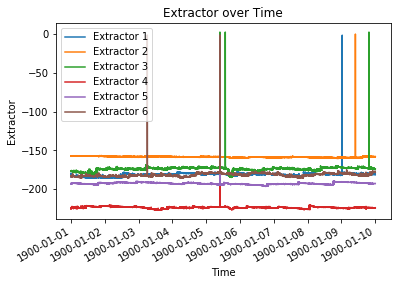

In [10]:
# Explore Extractor Columns
ax = raw_data.plot(x="Time", y=['Extractor 1', 'Extractor 2', 'Extractor 3', 'Extractor 4', 'Extractor 5', 'Extractor 6'])
ax.set_title("Extractor over Time")
ax.set_ylabel("Extractor")
ax.set_xlabel("Time")

Text(0.5,0,'Time')

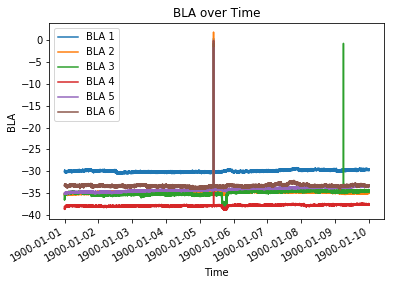

In [11]:
# Explore BLA columns, which relate to the "output" of our dataset
ax = raw_data.plot(x="Time", y=['BLA 1', 'BLA 2', 'BLA 3', 'BLA 4', 'BLA 5', 'BLA 6'])
ax.set_title("BLA over Time")
ax.set_ylabel("BLA")
ax.set_xlabel("Time")


Text(0.5,0,'Time')

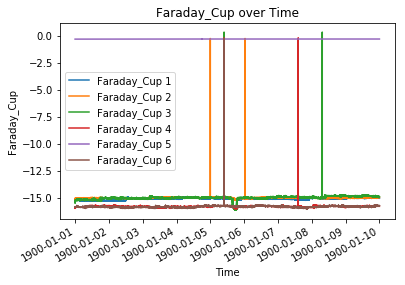

In [12]:
# Explore Extractor Columns
ax = raw_data.plot(x="Time", y=['Faraday_Cup 1', 'Faraday_Cup 2', 'Faraday_Cup 3', 'Faraday_Cup 4', 'Faraday_Cup 5', 'Faraday_Cup 6'])
ax.set_title("Faraday_Cup over Time")
ax.set_ylabel("Faraday_Cup")
ax.set_xlabel("Time")

Text(0.5,0,'Time')

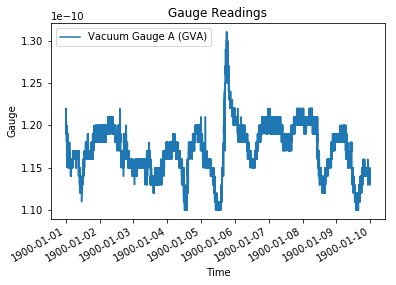

In [13]:
# Explore Gauges
ax = raw_data.plot(x="Time", y=['Vacuum Gauge A (GVA)'])
ax.set_title("Gauge Readings")
ax.set_ylabel("Gauge")
ax.set_xlabel("Time")

Text(0.5,0,'Time')

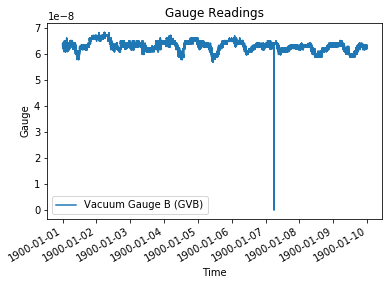

In [14]:
ax = raw_data.plot(x="Time", y=['Vacuum Gauge B (GVB)'])
ax.set_title("Gauge Readings")
ax.set_ylabel("Gauge")
ax.set_xlabel("Time")


Text(0.5,0,'Time')

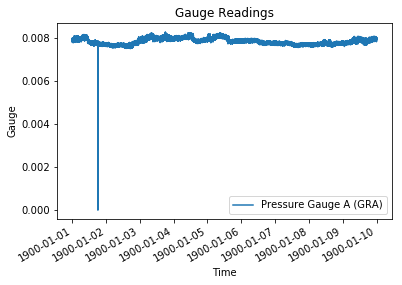

In [15]:
# Explore Gauges
ax = raw_data.plot(x="Time", y=['Pressure Gauge A (GRA)'])
ax.set_title("Gauge Readings")
ax.set_ylabel("Gauge")
ax.set_xlabel("Time")

